# Point Cloud Classification for Pix3D Dataset

In [ ]:
! pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.8/680.8 kB 16.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import shutil
import pandas as pd
import h5py
import zipfile
import cv2
import shutil
import zipfile
import os
import zipfile
import glob
import gc
import copy
import math
import warnings
import trimesh
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import xml.etree.ElementTree as ET # Parse XML Data.

from trimesh import creation, transformations
from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
from trimesh import creation, transformations

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Preparation

Download Dataset

In [ ]:
! wget http://pix3d.csail.mit.edu/data/pix3d.zip

--2023-04-11 14:01:40--  http://pix3d.csail.mit.edu/data/pix3d.zip
Resolving pix3d.csail.mit.edu (pix3d.csail.mit.edu)... 128.52.131.62
Connecting to pix3d.csail.mit.edu (pix3d.csail.mit.edu)|128.52.131.62|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783261880 (3.5G) [application/zip]
Saving to: ‘pix3d.zip’

pix3d.zip           100%[===================>]   3.52G  38.6MB/s    in 94s     

2023-04-11 14:03:15 (38.2 MB/s) - ‘pix3d.zip’ saved [3783261880/3783261880]



In [ ]:
! unzip -qq ./pix3d.zip

### Folder Preparation

Copy the folders only to another folder.

In [ ]:
! rm -rf obj_model
! mkdir obj_model
! find "./model" -type d -links 2 -exec mkdir -p "./obj_model/{}" \;
! find "./obj_model/model" -mindepth 2 -maxdepth 4  -type d -exec rm -rf {} \;

find: ‘./obj_model/model/table/IKEA_RAST’: No such file or directory
find: ‘./obj_model/model/table/IKEA_VITTSJO_1’: No such file or directory
find: ‘./obj_model/model/table/IKEA_NORDLI’: No such file or directory
find: ‘./obj_model/model/table/IKEA_INGATORP’: No such file or directory
find: ‘./obj_model/model/table/IKEA_FUSION’: No such file or directory
find: ‘./obj_model/model/table/IKEA_BJORKUDDEN_1’: No such file or directory
find: ‘./obj_model/model/table/IKEA_KLUBBO_1’: No such file or directory
find: ‘./obj_model/model/table/IKEA_KLUBBO_6’: No such file or directory
find: ‘./obj_model/model/table/IKEA_NYVOLL’: No such file or directory
find: ‘./obj_model/model/table/IKEA_NORDEN_3’: No such file or directory
find: ‘./obj_model/model/table/IKEA_LACK_3’: No such file or directory
find: ‘./obj_model/model/table/IKEA_INGO_1’: No such file or directory
find: ‘./obj_model/model/table/IKEA_NESNA’: No such file or directory
find: ‘./obj_model/model/table/IKEA_BJORKUDDEN_3’: No such file

Copy OBJ Files from model folder to obj_model folder.

In [ ]:
save_root_path = "./obj_model/model"
original_model_path = "./model"

model_index = 0
for root, dirs, files in os.walk(original_model_path, topdown = False):
  if len(root.split("/")) != 4:
    continue

  class_name = root.split("/")[2]

  for sample_file in files:
    if sample_file.endswith(".obj"):
      original_source_file_path = f"{root}/{sample_file}"
      copy_target_file_path = f"{save_root_path}/{class_name}/{sample_file}"
      new_target_file_path = f"{save_root_path}/{class_name}/model_{model_index}.obj"

      shutil.copyfile(original_source_file_path, copy_target_file_path)

      os.rename(copy_target_file_path, new_target_file_path)
      model_index += 1

## Data Preprocessing

Display one of object's file.

In [ ]:
mesh = trimesh.load("./obj_model/model/wardrobe/model_36.obj", force='mesh')
mesh.show()

See which formats that can be opened with Trimesh library.

In [ ]:
print(trimesh.exchange.load.available_formats())

{'tar.bz2', 'glb', 'gltf', '3mf', 'xaml', 'ply', 'xyz', 'obj', 'dict64', 'svg', '3dxml', 'json', 'dxf', 'off', 'stl_ascii', 'zip', 'stl', 'tar.gz', 'dict'}


Check one of Model's obj file in each class folders.

<trimesh.Trimesh(vertices.shape=(656, 3), faces.shape=(430, 3))>, path: ./obj_model/model/desk/model_2.obj
<trimesh.Trimesh(vertices.shape=(49958, 3), faces.shape=(100000, 3))>, path: ./obj_model/model/misc/model_27.obj
<trimesh.Trimesh(vertices.shape=(118, 3), faces.shape=(104, 3))>, path: ./obj_model/model/wardrobe/model_38.obj
<trimesh.Trimesh(vertices.shape=(49943, 3), faces.shape=(100000, 3))>, path: ./obj_model/model/tool/model_53.obj
<trimesh.Trimesh(vertices.shape=(1120, 3), faces.shape=(676, 3))>, path: ./obj_model/model/bookcase/model_61.obj
<trimesh.Trimesh(vertices.shape=(580, 3), faces.shape=(526, 3))>, path: ./obj_model/model/table/model_75.obj
<trimesh.Trimesh(vertices.shape=(993, 3), faces.shape=(628, 3))>, path: ./obj_model/model/sofa/model_141.obj
<trimesh.Trimesh(vertices.shape=(49875, 3), faces.shape=(100000, 3))>, path: ./obj_model/model/chair/model_468.obj
<trimesh.Trimesh(vertices.shape=(100, 3), faces.shape=(66, 3))>, path: ./obj_model/model/bed/model_729.obj


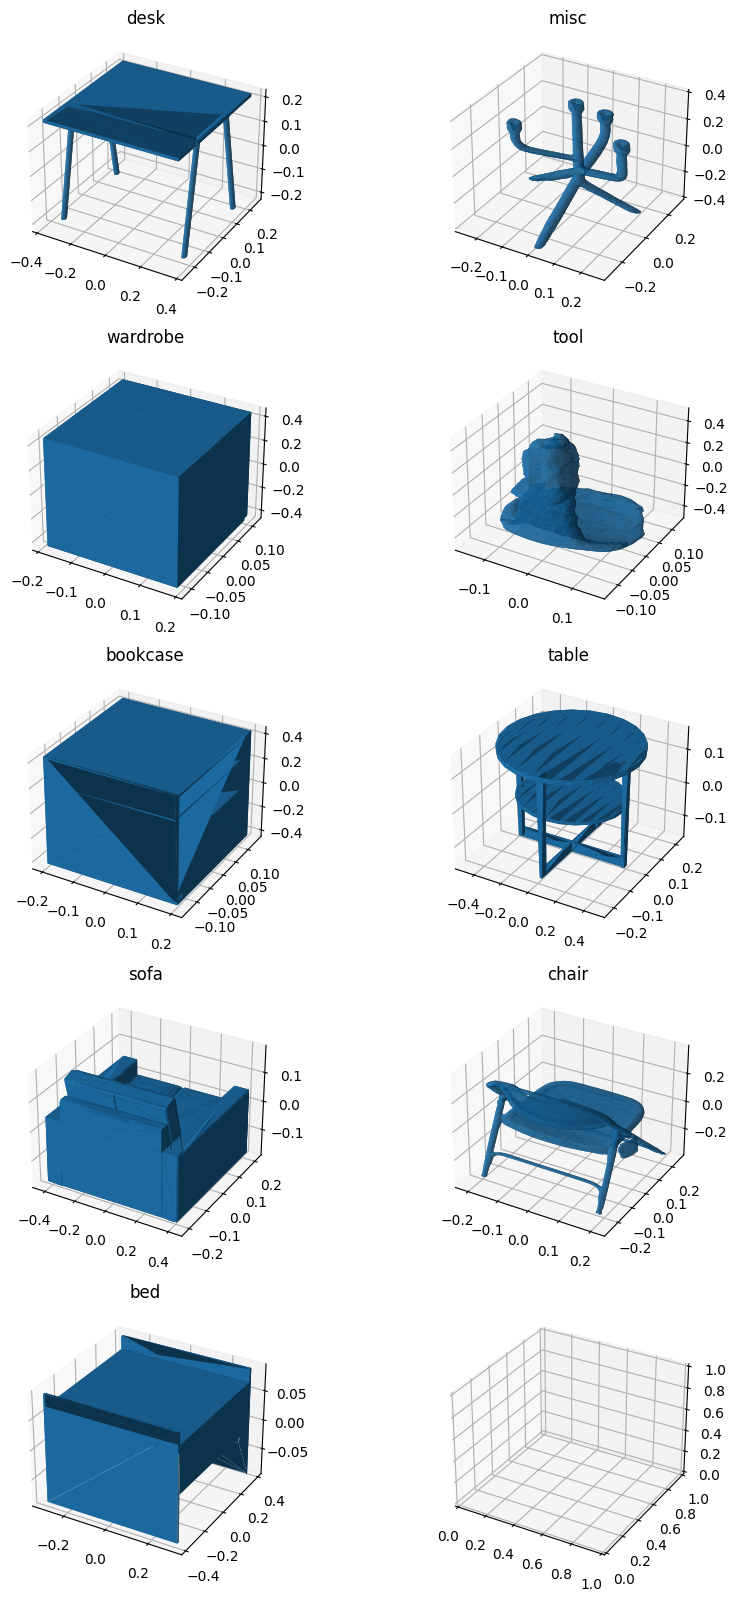

In [ ]:
new_model_path = "./obj_model/model/"

def get_rotated_mesh(mesh, angle, direction = [1, 0, 0], center = [0, 0, 0]):
  """
  NOTE: Make sure to use math.pi for this parameter!
  """
  rotation_matrix = transformations.rotation_matrix(angle, direction, center)
  mesh.apply_transform(rotation_matrix)
  return mesh

N_ROWS = 5
N_COLS = 2
fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (10, 20), subplot_kw = dict(projection='3d'))

for index, (root, dirs, files) in enumerate(os.walk(new_model_path, topdown = False)):
  row_index = int(index / N_COLS)
  col_index = index % N_COLS

  splitted_paths = root.split("/")
  splitted_paths = [splitted_path for splitted_path in splitted_paths if splitted_path] # Check if the string is not empty.
  if len(splitted_paths) != 4:
    continue
  try:
    # Sample a File Object
    sample_file_path = f"{root}/{files[0]}"

    # Preview an object
    mesh = trimesh.load(sample_file_path, force = "mesh")
    print(f"{mesh}, path: {sample_file_path}")

    rotation = math.pi / 2
    mesh = get_rotated_mesh(mesh, rotation)

    class_name = splitted_paths[3]
    ax = axes[row_index][col_index]
    ax.set_title(class_name)
    ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], triangles=mesh.faces);

  except IndexError as e:
    print(f"Error in: {sample_file_path} ({e})")

#   class_names = os.listdir(save_root_path)
#   print(class_names)

#   sample_path = "/content/model/bed/IKEA_BRIMNES_1/model.obj"
#

<trimesh.Trimesh(vertices.shape=(656, 3), faces.shape=(430, 3))>, path: ./obj_model/model/desk/model_2.obj
<trimesh.Trimesh(vertices.shape=(49958, 3), faces.shape=(100000, 3))>, path: ./obj_model/model/misc/model_27.obj
<trimesh.Trimesh(vertices.shape=(118, 3), faces.shape=(104, 3))>, path: ./obj_model/model/wardrobe/model_38.obj
<trimesh.Trimesh(vertices.shape=(49943, 3), faces.shape=(100000, 3))>, path: ./obj_model/model/tool/model_53.obj
<trimesh.Trimesh(vertices.shape=(1120, 3), faces.shape=(676, 3))>, path: ./obj_model/model/bookcase/model_61.obj
<trimesh.Trimesh(vertices.shape=(580, 3), faces.shape=(526, 3))>, path: ./obj_model/model/table/model_75.obj
<trimesh.Trimesh(vertices.shape=(993, 3), faces.shape=(628, 3))>, path: ./obj_model/model/sofa/model_141.obj
<trimesh.Trimesh(vertices.shape=(49875, 3), faces.shape=(100000, 3))>, path: ./obj_model/model/chair/model_468.obj
<trimesh.Trimesh(vertices.shape=(100, 3), faces.shape=(66, 3))>, path: ./obj_model/model/bed/model_729.obj


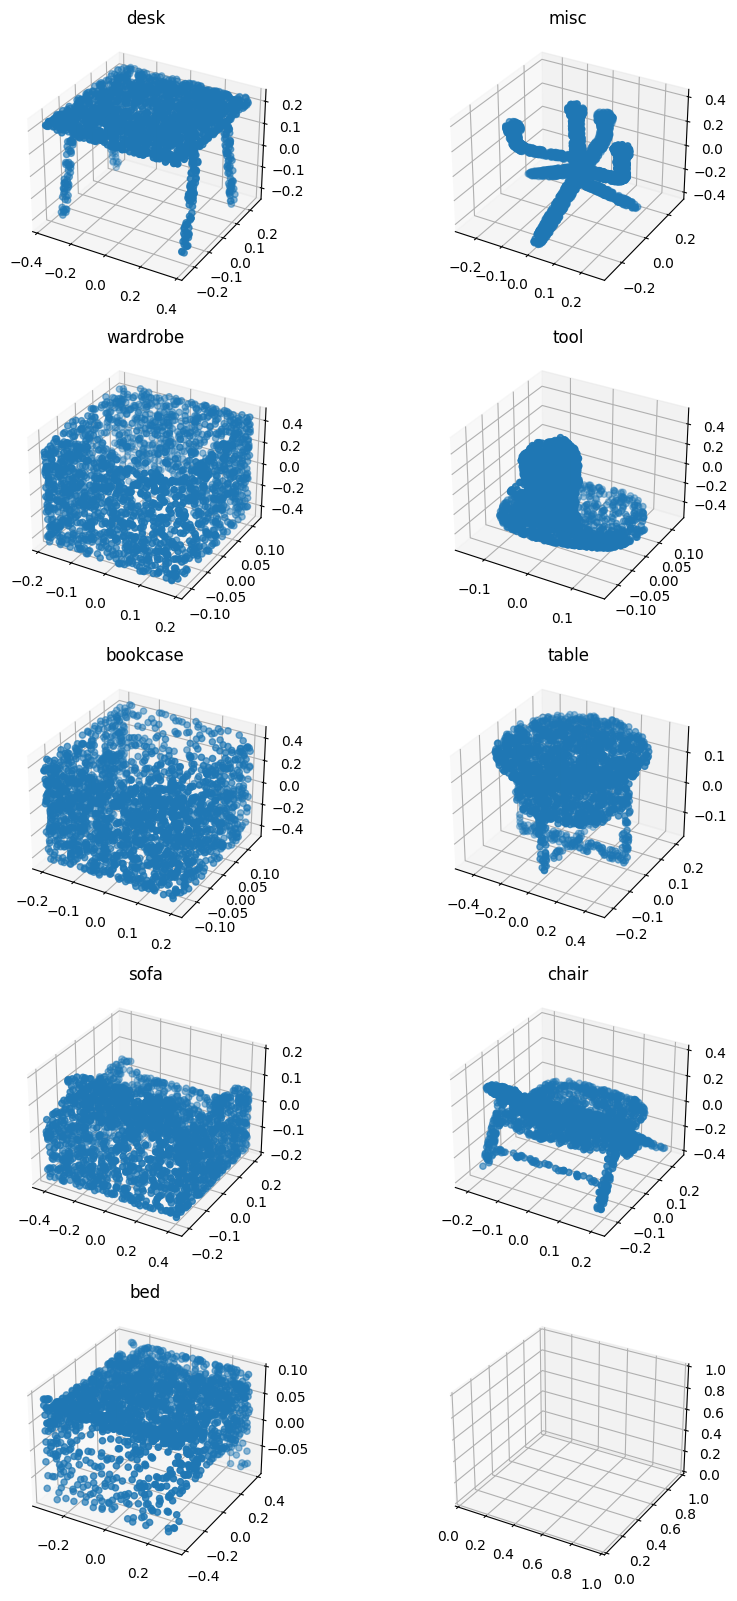

In [ ]:
fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (10, 20), subplot_kw = dict(projection='3d'))

for index, (root, dirs, files) in enumerate(os.walk(new_model_path, topdown = False)):
  row_index = int(index / N_COLS)
  col_index = index % N_COLS

  splitted_paths = root.split("/")
  splitted_paths = [splitted_path for splitted_path in splitted_paths if splitted_path] # Check if the string is not empty.
  if len(splitted_paths) != 4:
    continue
  try:
    # Sample a File Object
    sample_file_path = f"{root}/{files[0]}"

    # Preview an object
    mesh = trimesh.load(sample_file_path, force = "mesh")
    print(f"{mesh}, path: {sample_file_path}")

    rotation = math.pi / 2
    mesh = get_rotated_mesh(mesh, rotation)
    points = mesh.sample(2048)

    class_name = splitted_paths[3]
    ax = axes[row_index][col_index]
    ax.set_title(class_name)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])

  except IndexError as e:
    print(f"Error in: {sample_file_path} ({e})")

#   class_names = os.listdir(save_root_path)
#   print(class_names)

#   sample_path = "/content/model/bed/IKEA_BRIMNES_1/model.obj"
#

Make custom data loader

Debug Dataset: 


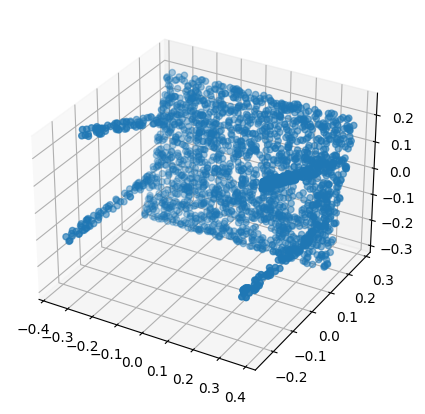

In [ ]:
class Pix3DDataset(Dataset):
  def __init__(self, root_path, CLASS_NAME_INDEX = 3):
    super(Pix3DDataset, self).__init__()
    self.root_path = root_path
    self.CLASS_NAME_INDEX = CLASS_NAME_INDEX
    self.class_to_index_dict = self.__class_dict__()
    self.obj_file_paths = glob.glob(os.path.join(root_path, "*/*.obj"))

  def __class_dict__(self):
    classes = glob.glob(os.path.join(self.root_path, "*"))
    class_to_index_dict = {class_name.split("/")[self.CLASS_NAME_INDEX]: index for index, class_name in enumerate(classes)}
    return class_to_index_dict

  def __get_rotated_mesh__(self, mesh, angle, direction = [1, 0, 0], center = [0, 0, 0]):
    """
    NOTE: Make sure to use math.pi for this parameter!
    """
    rotation_matrix = transformations.rotation_matrix(angle, direction, center)
    mesh.apply_transform(rotation_matrix)
    return mesh

  def __get_noised_points__(self, points, noise_value):
    points += noise_value
    return points

  def __getitem__(self, index):
    rotation_value = random.uniform(-30, 30)
    noise_value = random.uniform(-0.009, 0.009)

    obj_file_path = self.obj_file_paths[index]
    class_name = obj_file_path.split("/")[self.CLASS_NAME_INDEX]
    class_index = self.class_to_index_dict[class_name]

    mesh = trimesh.load(obj_file_path, force = "mesh")
    mesh = self.__get_rotated_mesh__(mesh, rotation_value)

    points = mesh.sample(2048)
    points = self.__get_noised_points__(points, noise_value)

    points = torch.Tensor(points)
    class_index = torch.tensor(class_index, dtype = torch.int64)

    return points, class_index

  def __len__(self):
    return len(self.obj_file_paths)

pix_3d_dataset = Pix3DDataset(
  "./obj_model/model/",
)

print("Debug Dataset: ")
sample_point = pix_3d_dataset[0][0]
sample_label = pix_3d_dataset[0][1]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5), subplot_kw = dict(projection='3d'))
ax.scatter(sample_point[:, 0], sample_point[:, 1], sample_point[:, 2])

Make Data Loaders

In [ ]:
pix3d_data_loader = DataLoader(
    pix_3d_dataset,
    batch_size = 16,
)

torch.Size([16, 2048, 3])


<Figure size 1500x1500 with 0 Axes>

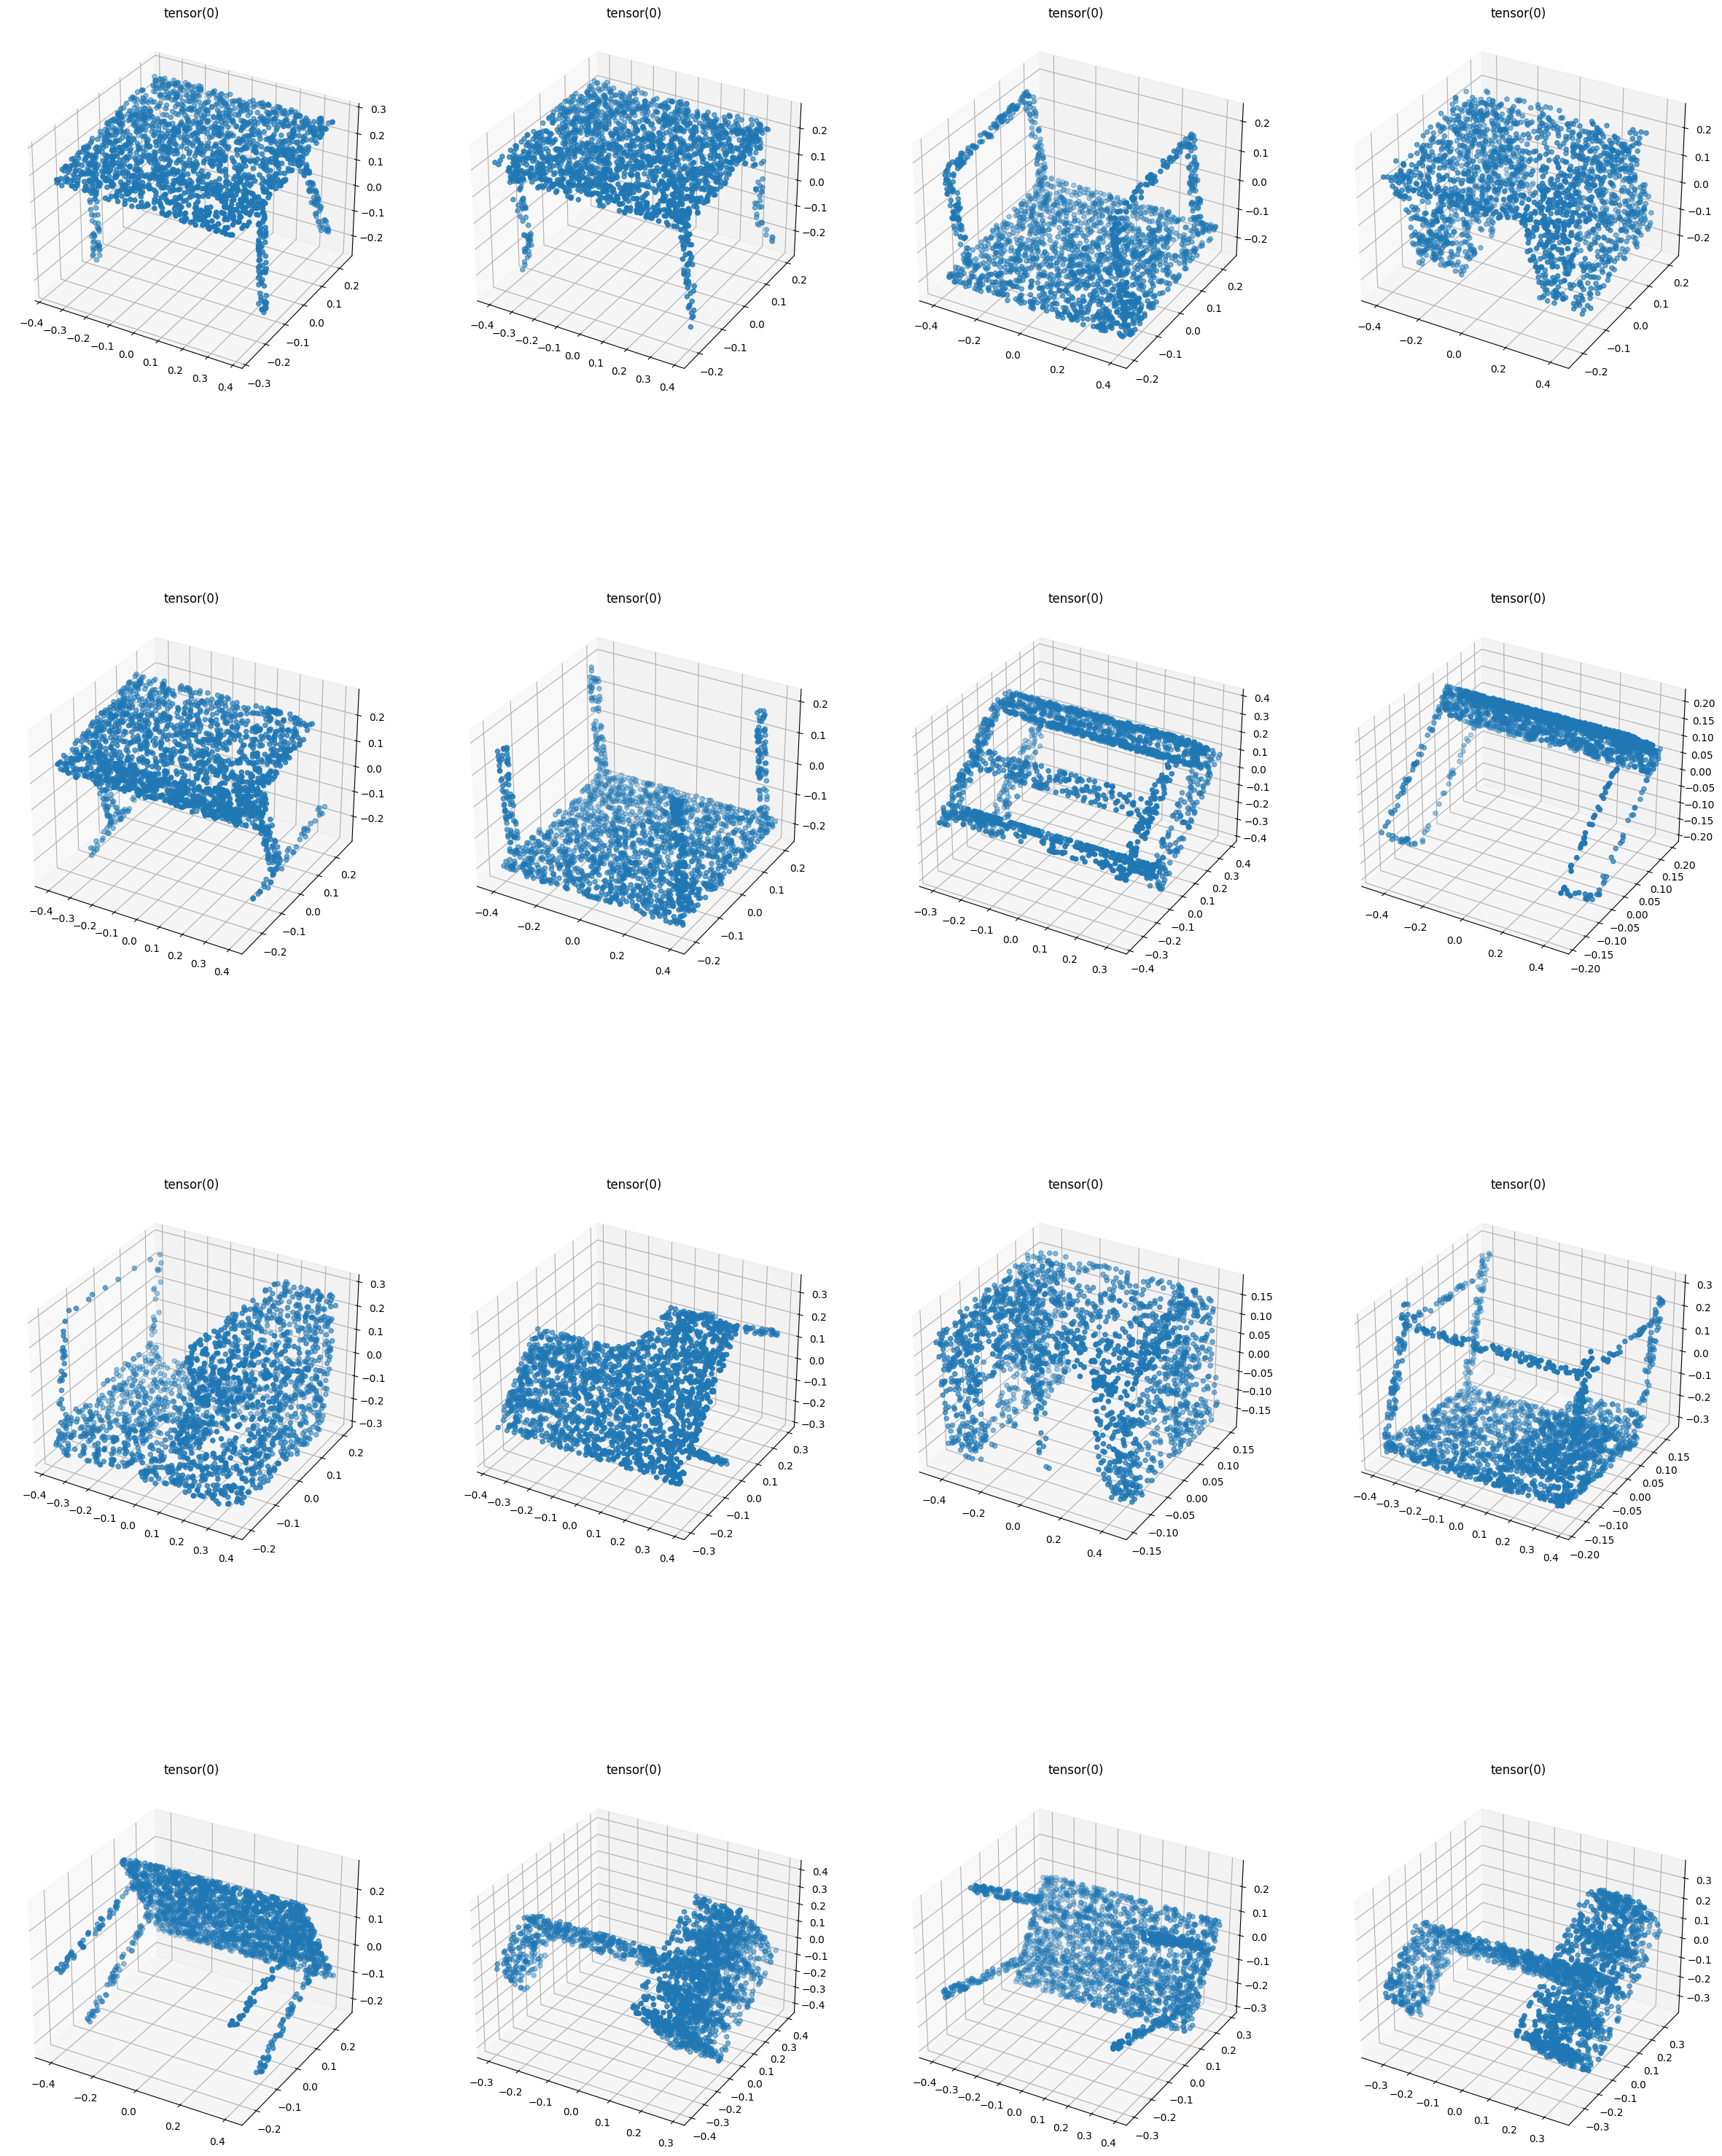

In [ ]:
def plot_images_in_grid(title, images, labels, figsize = (15, 15), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = figsize)
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_pytorch_grid(points_in_batch, labels_in_batch):
  plt.figure(figsize = (15, 15))
  print(points_in_batch.shape)

  N_ROWS = 4
  N_COLS = 4
  fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (30, 40), subplot_kw = dict(projection='3d'))

  for index, points in enumerate(points_in_batch):
    row_index = int(index / N_COLS)
    col_index = index % N_COLS

    ax = axes[row_index][col_index]
    ax.set_title(labels_in_batch[index])
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  sample_points_batch, label_batch = next(iter_loader)

  visualize_pytorch_grid(sample_points_batch, label_batch)

visualize_dataloader(pix3d_data_loader, "Pix3D Transformed Image")

## Data Modelling

In [ ]:
class OrthogonalRegularizer(nn.Module):
  def __init__(self, num_features, l2_reg = 0.001):
    super(OrthogonalRegularizer, self).__init__()
    self.num_features = num_features
    self.l2_reg = l2_reg
    self.eye = torch.eye(num_features)

  def forward(self, x):
    x = torch.reshape(x, (-1, self.num_features, self.num_features))
    print(x.shape)
    x_xt = torch.tensordot(x, x, dims = 2)
    x_xt = torch.reshape(x_xt, (-1, self.num_features, self.num_features))
    return torch.reduce_sum(self.l2reg * torch.square(x_xt - self.eye))

Make Model Architecture.

Paper Reference:
https://arxiv.org/pdf/1612.00593

In [ ]:
class PointNet(nn.Module):
  def __init__(self):
    super(PointNet, self).__init__()
    self.global_max_pooling = torch.nn.Sequential(
      torch.nn.AdaptiveMaxPool1d(1), # Get top 1 max value across all filters.
      torch.nn.Flatten(), # Remove "1" from the Max Pooling Layers.
    )

  def __get_conv_layer__(self, pre_number_filters, post_number_filters, momentum = 0.0):
    return nn.Sequential(
        nn.Conv1d(pre_number_filters, post_number_filters, kernel_size = 1),
        nn.BatchNorm1d(post_number_filters, momentum = momentum),
        nn.ReLU(),
    )

  def __get_dense_layer__(self, pre_number_filters, post_number_filters, momentum = 0.0):
    return nn.Sequential(
        nn.Linear(pre_number_filters, post_number_filters),
        nn.BatchNorm1d(post_number_filters, momentum = momentum),
        nn.ReLU(),
    )

class TNet(PointNet):
  def __init__(self, in_features, num_features):
    super(TNet, self).__init__()
    self.num_features = num_features
    self.in_features = in_features
    self.orthogonal_regularizer = OrthogonalRegularizer(num_features = self.num_features)

    self.conv_1 = self.__get_conv_layer__(self.in_features, 32)
    self.conv_2 = self.__get_conv_layer__(32, 64)
    self.conv_3 = self.__get_conv_layer__(64, 512)
    # self.global_max_pooling_1 = self.global_max_pooling()
    self.dense_1 = self.__get_dense_layer__(512, 256)
    self.dense_2 = self.__get_dense_layer__(256, 128)
    self.dense_3 = nn.Linear(
      128,
      self.num_features * self.num_features,
    )

  def forward(self, x):
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.global_max_pooling(x)
    x = self.dense_1(x)
    x = self.dense_2(x)
    x = self.dense_3(x)
    x = self.orthogonal_regularizer(x)

    x_T = x.view((-1, self.num_features, self.num_features))(x)

     # Apply affine transformation.
    return x_T

class Pix3DPointNet(PointNet):
  def __init__(self, in_features, num_features):
    super(Pix3DPointNet, self).__init__()
    self.in_features = in_features
    self.num_features = num_features
    self.tnet_1 = TNet(self.in_features, 3)
    self.conv_1 = self.__get_conv_layer__(3, 32)
    self.conv_2 = self.__get_conv_layer__(32, 32)
    self.tnet_2 = TNet(32, 32)
    self.conv_3 = self.__get_conv_layer__(32, 32)
    self.conv_4 = self.__get_conv_layer__(32, 64)
    self.conv_5 = self.__get_conv_layer__(64, 512)
    # self.global_max_pooling_1 = self.global_max_pooling()
    self.dense_1 = self.__get_dense_layer__(512, 256)
    self.dense_2 = self.__get_dense_layer__(256, 128)
    self.dense_3 = nn.Linear(
        128, self.num_features
    )

  def forward(self, x):
    x = self.tnet_1(x)

    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.conv_3(x)

    x = self.tnet_2(x)

    x = self.conv_4(x)
    x = self.conv_5(x)
    x = self.conv_6(x)

    x = self.global_max_pooling(x)

    x = self.dense_1(x)
    x = nn.Dropout(0.3)(x)
    x = self.dense_2(x)
    x = nn.Dropout(0.3)(x)
    x = self.dense_3(x)

    return x


pix_3d_point_net = Pix3DPointNet(in_features = 2048, num_features = 9)
pix_3d_point_net

Pix3DPointNet(
  (global_max_pooling): Sequential(
    (0): AdaptiveMaxPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (tnet_1): TNet(
    (global_max_pooling): Sequential(
      (0): AdaptiveMaxPool1d(output_size=1)
      (1): Flatten(start_dim=1, end_dim=-1)
    )
    (orthogonal_regularizer): OrthogonalRegularizer()
    (conv_1): Sequential(
      (0): Conv1d(2048, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.0, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv_2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.0, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv_3): Sequential(
      (0): Conv1d(64, 512, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.0, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (dense_1): Sequential(
      (0): Linear(in_features=51

Test the Model.

In [ ]:
epochs = 10

pix_3d_point_net =  Pix3DPointNet(in_features = 2048, num_features = 9).to(device)
optimizer = optim.Adam(pix_3d_point_net.parameters(), lr = 0.00001)
loss_func = nn.CrossEntropyLoss()
loss_history = []
iterations = []

for epoch in range(epochs):
  total_loss = 0
  for train_iteration, (points, labels) in enumerate(pix3d_data_loader):
    points = points.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = pix_3d_point_net(points)

    loss = loss_func(outputs, labels)
    total_loss += loss.item()
    loss_func.backward()
    optimizer.step()

    if train_iteration % 10 == 0:
      print(f"Current Epoch: {epoch}, iteration = {train_iteration}, with current loss: {loss.item()}")
      loss_history.append(loss.item())
      iterations.append(train_iteration)

torch.Size([16, 3, 3])


RuntimeError: ignored